# 13.6. 目标检测数据集
目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。为了快速测试目标检测模型，**我们收集并标记了一个小型数据集**。首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。然后，我们在一些背景图片的随机位置上放一张香蕉的图像。最后，我们在图片上为这些香蕉标记了边界框。

## 13.6.1. 下载并读取数据集


In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

"""
包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载。
"""

#@save
d2l.DATA_HUB['banana-detection']=(d2l.DATA_URL+'banana-detection.zip','5de26c8fce5ccdea9f91267273464dc968d20d72')

"""
通过read_data_bananas函数，我们读取香蕉检测数据集。 该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。
"""
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir=d2l.download_extract('banana-detection')
    csv_fname=os.path.join(data_dir,'bananas_train' if is_train else 'bananas_val','label.csv')
    csv_data=pd.read_csv(csv_fname)
    csv_data=csv_data.set_index('img_name')

    images,targets=[],[]
    for img_name,target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir,'bananas_train' if is_train else 'bananas_val','images',f'{img_name}')
        ))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images,torch.tensor(targets).unsqueeze(1) / 256

"""
通过使用read_data_bananas函数读取图像和标签，以下BananasDataset类别将允许我们创建一个自定义Dataset实例来加载香蕉检测数据集。
"""
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self,is_train):
        self.features,self.labels=read_data_bananas(is_train)
        print('read '+str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))

    # 读取第idx个样本
    def __getitem__(self, idx):
        return (self.features[idx].float(),self.labels[idx])


    def __len__(self):
        return len(self.features)

"""
最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。

对于测试集，无须按随机顺序读取它。
"""
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""

    train_iter=torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                           batch_size,
                                           shuffle=True)

    val_iter=torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                         batch_size)
    return train_iter,val_iter

让我们**读取一个小批量，并打印其中的图像和标签的形状**。图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。这样，每个边界框的标签将被长度为5的数组表示。数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0到1之间）。对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。

In [2]:
batch_size,edge_size=32,256
train_iter,_=load_data_bananas(batch_size)
batch=next(iter(train_iter))
batch[0].shape,batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## 13.6.3. 演示
让我们展示10幅带有真实边界框的图像。我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。

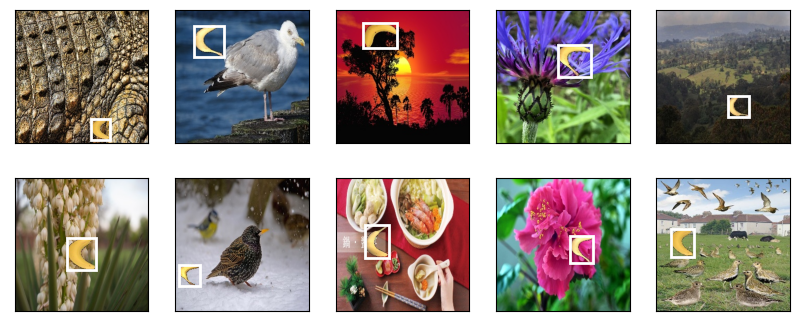

In [3]:
imgs=(batch[0][0:10].permute(0,2,3,1)) / 255
axes=d2l.show_images(imgs,2,5,scale=2)
for ax,label in zip(axes,batch[1][0:10]):
    d2l.show_bboxes(ax,[label[0][1:5] * edge_size ],colors=['w'])

## 13.6.4. 小结
- 我们收集的香蕉检测数据集可用于演示目标检测模型。

- 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。